# Sistema de predicción de ventas

Introduccion:

Queremos establecer el almacén de nuestra empresa en otra localización y necesitamos estimar el ritmo de las ventas, que desde la creación de la empresa ha ido en aumento, para los próximos meses, a fin de proveer el espacio que necesitaremos.

# Paso 1: Importar librerias

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import pickle
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# Paso 2: Cargar dataset

In [2]:
url = "https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv"
df = pd.read_csv(url)
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


# Paso 3: Exploracion de datos

In [3]:
# filas y columnas de un DataFrame.
df.tail()

,date,sales
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214
365,2023-09-03 17:10:08.079328,1000.482785


In [4]:
# datos de cada columna de un DataFrame.
df.dtypes

date      object
sales    float64
dtype: object

In [5]:
# Comprobación de valores NaN
df.isna().mean()*100

date     0.0
sales    0.0
dtype: float64

In [6]:
# Comprobación de valores faltantes
df.isnull().sum()

date     0
sales    0
dtype: int64

In [7]:
# Comprobando si hay duplicados
df.duplicated().sum()

np.int64(0)

In [8]:
# Comprobación de valores únicos
df.nunique()

date     366
sales    366
dtype: int64

Conclusiones:

-El conjunto de datos tiene 366 filas y 2 columnas: "Fecha" y "Ventas".

Los tipos de datos son:

-Fecha: objeto (necesita ser convertido a formato datetime).

-Ventas: float.

-No hay valores faltantes ni filas con NaN.

-No hay filas duplicadas.

-El número de valores únicos es consistente con la naturaleza del conjunto de datos (366 fechas únicas).

Convertir la columna "Fecha" a formato datetime para poder trabajar con ella de manera efectiva y estimar la tasa de ventas.

In [9]:
# Cambiar el tipo de datos "date" del formato de objeto al formato de fecha y hora
df['date'] = pd.to_datetime(df['date'])
df.dtypes

date     datetime64[ns]
sales           float64
dtype: object

Ahora establezcamos la fecha como nuestro nuevo índice

In [10]:
# Establecer fecha como índice
df.set_index('date', inplace=True)
df

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633
...,...
2023-08-30 17:10:08.079328,989.600354
2023-08-31 17:10:08.079328,994.987326
2023-09-01 17:10:08.079328,995.814415


Ahora necesitamos organizar (ordenar) nuestra df por fecha (nuestro nuevo índice)

In [11]:
df.sort_values('date')
df

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633
...,...
2023-08-30 17:10:08.079328,989.600354
2023-08-31 17:10:08.079328,994.987326
2023-09-01 17:10:08.079328,995.814415


Ahora que los datos están preparados, busquemos el tensor

In [12]:
# Comprobar cuál es la unidad de tiempo más pequeña en la que se miden los datos (en qué unidad de tiempo se registraron los datos)
df.index.to_series().diff().value_counts()

date
1 days    365
Name: count, dtype: int64

Como podemos ver, nuestro tensor es diario (1 día).

Ahora, graficamos la serie temporal para analizar la tendencia, comprobar si es estacionaria y si hay ruido (variabilidad).

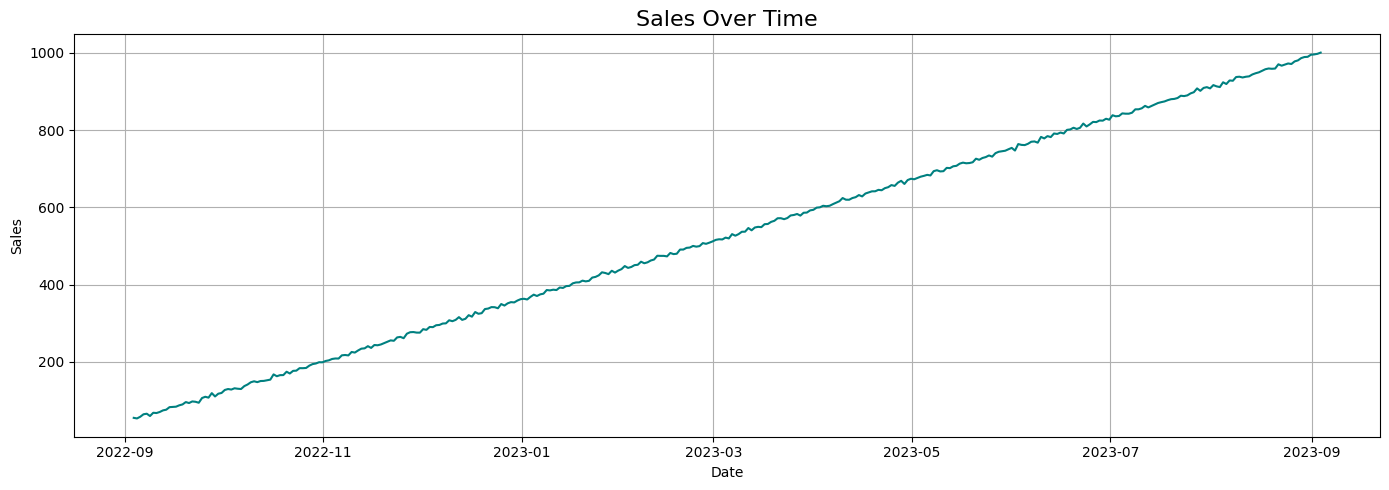

In [13]:
# Plots
plt.figure(figsize=(14, 5))
plt.plot(df['sales'], color='teal')
plt.title('Sales Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

Conclusiones: 
- Comportamiento de las ventas: El proyecto indica que la tasa de ventas ha aumentado desde la creación de la empresa, lo que se confirma al observar la gráfica, que muestra una tendencia ascendente fuerte y consistente.

- Ruido (variabilidad): La señal es casi perfectamente suave, con fluctuaciones muy pequeñas y un ruido muy leve que no interrumpe la tendencia general.

- Estacionalidad: No se observa un patrón estacional claro, ya que la tendencia es suave y no hay ritmos ascendentes y descendentes típicos de la estacionalidad (como diferencias entre días de semana y fines de semana).

- Descomposición de la serie temporal: Para analizar más a fondo, se descompondrá la serie temporal en tres partes principales:

-Tendencia: La dirección general de la serie temporal.

-Estacionalidad: Los patrones que se repiten en intervalos regulares.

-Residual (ruido): Las fluctuaciones aleatorias que no se explican por la tendencia o la estacionalidad.

Descomponiendo la serie

In [14]:
decomposition = seasonal_decompose(df['sales'], model='additive', period=7)

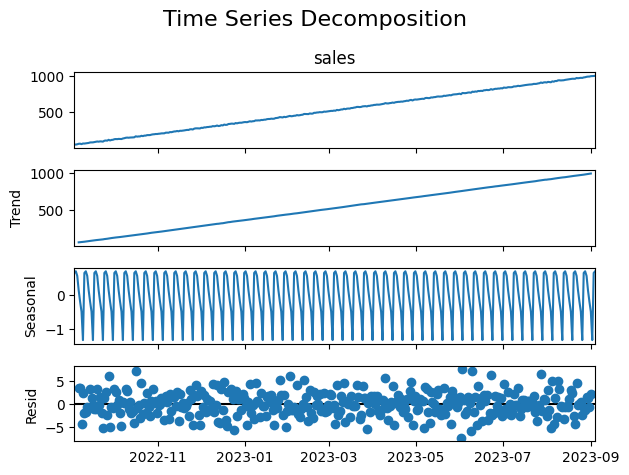

In [ ]:
#Ploting
decomposition.plot()
plt.suptitle('Time Series Decomposition', fontsize=16)
plt.tight_layout()
plt.show()

Conclusiones

- Análisis de la serie temporal:

Después de descomponer la serie temporal, se observa que:

-Tendencia: La serie temporal muestra una tendencia ascendente clara y consistente, lo que indica un aumento constante en las ventas a lo largo del tiempo.

- Patrón estacional: 

-Se detecta un patrón estacional débil pero regular, probablemente relacionado con ciclos de ventas semanales, aunque su impacto es relativamente menor en comparación con la tendencia general.

- Residuos: 

-Los residuos parecen estables y centrados alrededor de cero, lo que indica un ruido mínimo en la serie temporal.

- Prueba de estacionariedad: 

-Se realizará una prueba ADF (Augmented Dickey-Fuller) para determinar si la serie temporal es estacionaria.

- Criterio de estacionariedad: Si el p-valor es < 0,05, se concluye que la serie temporal es estacionaria. De lo contrario, si el p-valor es ≥ 0,05, se considera que la serie temporal no es estacionaria y se necesitará transformarla para utilizar modelos como ARIMA.

Realizar prueba del ADF

In [16]:
result = adfuller(df['sales'])

#Results
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value {key}: {value}")

ADF Statistic: 0.545414193706378
p-value: 0.9861899815311064
Critical Value 1%: -3.4490648539347544
Critical Value 5%: -2.8697861692116478
Critical Value 10%: -2.5711631253228306


Conclusiones:

- El valor p de la prueba ADF es 0,986, lo que indica que la serie temporal no es estacionaria.

- Esto era esperado debido a la fuerte tendencia observada en la gráfica y la descomposición.

- Para hacer que la serie temporal sea estacionaria, se necesita aplicar diferenciación, es decir, eliminar las tendencias o la estacionalidad antes de modelarla con ARIMA.

Diferenciando para hacerlo estacionario

In [17]:
df['sales_diff'] = df['sales'].diff()
df_diff = df.dropna() 

Comprobación del valor p ahora que nuestra serie temporal ha sido diferenciada

In [18]:
result_diff = adfuller(df_diff['sales_diff'])
print(f"ADF Statistic (diff): {result_diff[0]}")
print(f"p-value (diff): {result_diff[1]}")

ADF Statistic (diff): -9.430263118334729
p-value (diff): 5.212954111417404e-16


- Se aplicó la diferenciación de primer orden a la serie temporal, lo que eliminó la tendencia.

- La prueba ADF posterior confirmó que la serie temporal ahora es estacionaria, con un p-valor muy bajo (< 0,0001) y un estadístico de prueba altamente negativo.

Respuestas a las preguntas:

-Frecuencia de la serie temporal: Diaria (1 día).

-Tendencia: Fuerte tendencia ascendente (ya no existe después de la transformación).

-Estacionariedad: No era estacionaria inicialmente, pero ahora sí lo es después de la transformación.

-Variabilidad o ruido: Los residuos son estables y centrados alrededor de cero, lo que indica un ruido mínimo.

-Ahora que los datos están preparados en formato de serie temporal, se puede proceder a dividir los datos para continuar con el análisis.

Partición de datos

In [19]:
split_idx = int(len(df) * 0.8)  # 80% train

df_train = df.iloc[:split_idx]
df_test = df.iloc[split_idx:]

In [20]:
# train número de filas y columnas del DataFrame 
df_train.shape

(292, 2)

In [21]:
# test número de filas y columnas del DataFrame
df_test.shape

(74, 2)

Para identificar adecuadamente los mejores parámetros para el modelo ARIMA (p, d, q), utilizaremos gráficos automáticos ACF y PACF

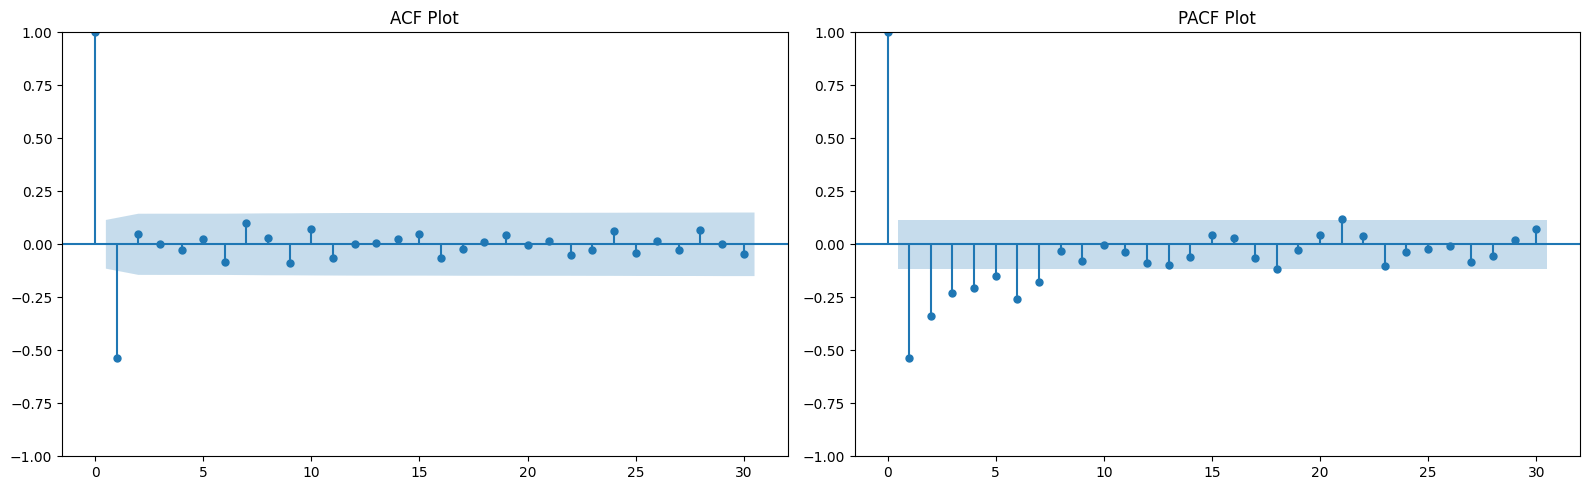

In [22]:
# Usando diferenciado series (d=1)
diff_series = df_train['sales'].diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

#ACF (for q)
plot_acf(diff_series, ax=axes[0], lags=30)
axes[0].set_title("ACF Plot")

#PACF (for p)
plot_pacf(diff_series, ax=axes[1], lags=30, method='ywm')
axes[1].set_title("PACF Plot")

plt.tight_layout()
plt.show()

- Los gráficos de ACF (Autocorrelación) y PACF (Autocorrelación parcial) muestran un pico significativo en el retardo 1, lo que indica dependencias a corto plazo en la serie temporal.
- El ACF sugiere un proceso MA(1) (media móvil de orden 1), mientras que el PACF sugiere un proceso AR(1) (autoregresivo de orden 1), con influencia mínima más allá del retardo 1.
- Combinando esta información con la prueba de estacionariedad previa (d=1), un buen modelo ARIMA inicial para probar es ARIMA(1,1,1).
- Ahora se entrenará el modelo utilizando los parámetros sugeridos por los gráficos de ACF y PACF.

# Paso 4: Entrenamiento del modelo ARIMA

In [23]:
model = ARIMA(df_train['sales'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  292
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -838.546
Date:                Sun, 24 Aug 2025   AIC                           1683.092
Time:                        08:59:45   BIC                           1694.112
Sample:                    09-03-2022   HQIC                          1687.506
                         - 06-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.001   1863.304      0.000       0.999       1.001
ma.L1         -0.9996      0.473     -2.111      0.035      -1.928      -0.072
sigma2        18.3520      8.857      2.072      0.0

Conclusiones:

- El modelo ARIMA(1,1,1) se ajusta razonablemente bien a los datos.
- Los términos AR(1) y MA(1) son altamente significativos (P < 0,05), lo que indica que el modelo captura efectivamente las dependencias a corto plazo.
- La varianza residual (18,35) sugiere un ruido relativamente bajo.
- Sin embargo, el test de Ljung-Box indica que todavía hay autocorrelación en los residuos (p-valor = 0,00), lo que sugiere que el modelo podría mejorar.
- Los residuos parecen distribuirse normalmente (p-valor de Jarque-Bera ≈ 0,25).
- A continuación, se procederá a realizar predicciones con el conjunto de prueba según las instrucciones del proyecto.

# Paso 5: Predicción con el conjunto de prueba

In [35]:
# Definir la longitud de la predicción
n_predictions = len(df_test)

In [36]:
# Generar predicción para el período de prueba
predictions_result = model_fit.get_forecast(steps=n_predictions)

In [37]:
# Extracción de la media y los coeficientes previstos
predictions_mean = predictions_result.predicted_mean
predictions_ci = predictions_result.conf_int()

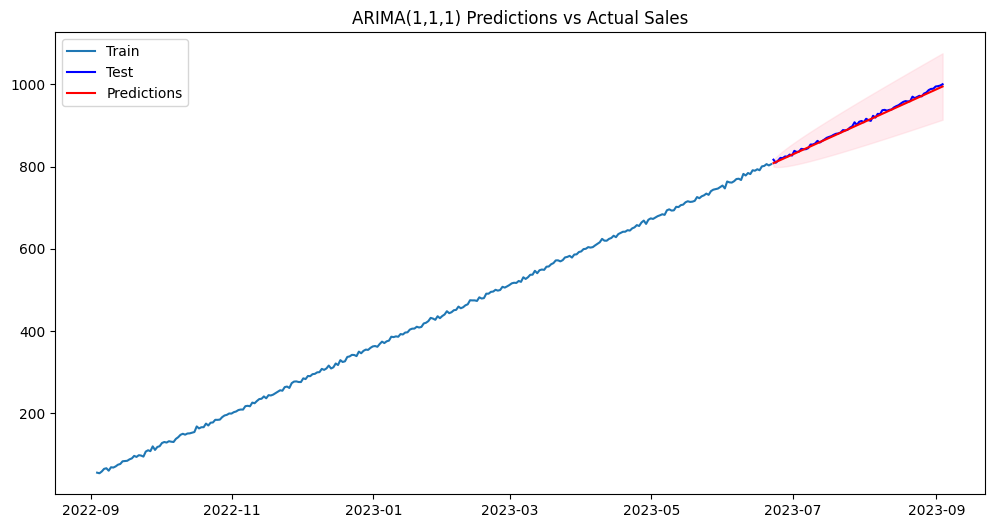

In [38]:
# plots
plt.figure(figsize=(12,6))
plt.plot(df_train.index, df_train['sales'], label='Train')
plt.plot(df_test.index, df_test['sales'], label='Test', color='blue')
plt.plot(df_test.index, predictions_mean, label='Predictions', color='red')

# Intervalos de confianza de shade
plt.fill_between(df_test.index,
                 predictions_ci.iloc[:, 0],
                 predictions_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.legend()
plt.title('ARIMA(1,1,1) Predictions vs Actual Sales')
plt.show()

Conclusiones:

- El modelo ARIMA captura adecuadamente la tendencia al alza de los datos.
- Las predicciones se alinean estrechamente con las ventas reales.

- El modelo demuestra ser estable y eficaz para la previsión a corto plazo en este conjunto de datos.

In [28]:
# Métricas de error
mae = mean_absolute_error(df_test['sales'], predictions_mean)
rmse = np.sqrt(mean_squared_error(df_test['sales'], predictions_mean))
mape = np.mean(np.abs((df_test['sales'] - predictions_mean) / df_test['sales'])) * 100

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")

MAE: 3.288
RMSE: 4.073
MAPE: 0.36%


- El modelo ARIMA(1,1,1) se entrenó con éxito en los datos históricos de ventas y se utilizó para predecir ventas en el período de prueba.
- Las métricas de rendimiento del modelo son:
- MAE (Error absoluto medio): 3,29
- RMSE (Raíz del error cuadrático medio): 4,07
- MAPE (Error porcentual absoluto medio): 0,36%
- Estas métricas demuestran que el modelo predice las ventas con alta precisión, con un error porcentual promedio inferior al 0,5%.
- El bajo MAPE confirma que el modelo captura patrones subyacentes en los datos de manera confiable, lo que lo hace una opción sólida para la previsión de ventas a corto plazo.
- La inspección visual de las predicciones versus las ventas reales muestra una buena alineación, lo que confirma la aplicabilidad práctica del modelo para la toma de decisiones informadas.
- La precisión del modelo es excelente, con un MAPE de 0,36%, lo que significa que las predicciones se desvían en promedio menos del 0,5% de los valores reales de ventas.

Ventas previstas DF

In [29]:
predicted_sales_df = pd.DataFrame({
    'predicted_sales': predictions_mean.values,
    'lower_ci': predictions_ci.iloc[:, 0].values,
    'upper_ci': predictions_ci.iloc[:, 1].values
}, index=df_test.index)
predicted_sales_df.index.name = 'date'

Para obtener una comprensión más profunda de los datos históricos y los datos de ventas predichos, se realizará una comparación breve entre ambos conjuntos de datos.

In [30]:
# Cuánto aumentaron las ventas a lo largo del tiempo según los datos de la empresa (datos históricos)

# Medir el crecimiento total
initial_sales = df['sales'].iloc[0]
final_sales = df['sales'].iloc[-1]

# Crecimiento absoluto y porcentual
absolute_growth = final_sales - initial_sales
percentage_growth = (absolute_growth / initial_sales) * 100

print("Real Sales Growth (Historical Data)\n")
print(f"Absolute growth: {absolute_growth:.2f}")
print(f"Percentage growth: {percentage_growth:.2f}%")


Real Sales Growth (Historical Data)

Absolute growth: 945.19
Percentage growth: 1709.45%


Este es un crecimiento masivo, lo que indica que las ventas aumentaron drásticamente durante el año observado. La tendencia al alza que observamos anteriormente en los gráficos de líneas y la descomposición lo confirma.

In [31]:
# Crecimiento de ventas previsto según el modelo
initial_predictions = predicted_sales_df['predicted_sales'].iloc[0]
final_predictions = predicted_sales_df['predicted_sales'].iloc[-1]

predictions_growth = final_predictions - initial_predictions
predictions_growth_pct = (predictions_growth / initial_predictions) * 100

print("Predicted Sales Growth (Model data)\n")
print(f"Predictions absolute growth: {predictions_growth:.2f}")
print(f"Predictions growth percentage: {predictions_growth_pct:.2f}%")

Predicted Sales Growth (Model data)

Predictions absolute growth: 186.49
Predictions growth percentage: 23.07%


conclusiones:

- El modelo predice un aumento constante pero más lento en comparación con el crecimiento histórico.
- Entre septiembre de 2022 y septiembre de 2023, la empresa experimentó un crecimiento del 1709% en ventas, lo que indica una expansión rápida del negocio.
- En contraste, el modelo ARIMA(1,1,1) predice un crecimiento más conservador del 23% en un período de prueba de 2,5 meses.
- La discrepancia se debe en parte a que ARIMA es un modelo lineal que tiende a suavizar tendencias de crecimiento bruscas y a que el período de predicción es más corto.
- A pesar de esto, el modelo captura la trayectoria general al alza de las ventas.

Visualicemos la conclusión antes mencionada.

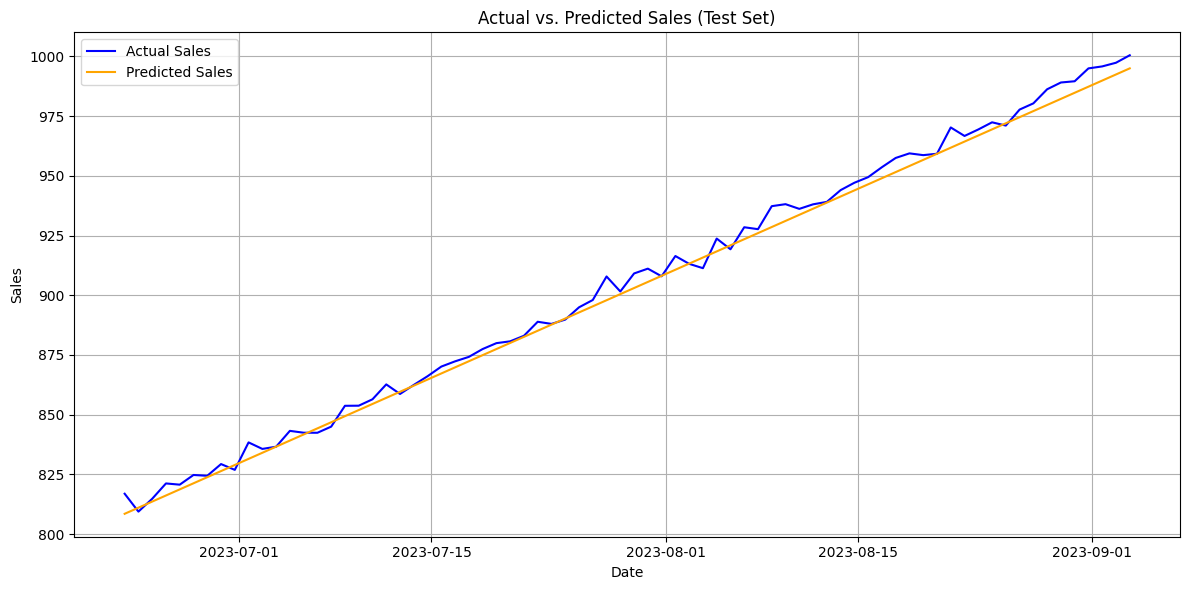

In [32]:
# Comparación cercana entre el gráfico de ventas reales y las previstas 

# Previo a la prueba
forecast_steps = len(df_test)
forecast = model_fit.forecast(steps=forecast_steps)


plt.figure(figsize=(12, 6))

# Ventas actuales
plt.plot(df_test.index, df_test['sales'], label='Actual Sales', color='blue')

# Ventas previstas
plt.plot(df_test.index, forecast, label='Predicted Sales', color='orange')

plt.title('Actual vs. Predicted Sales (Test Set)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()

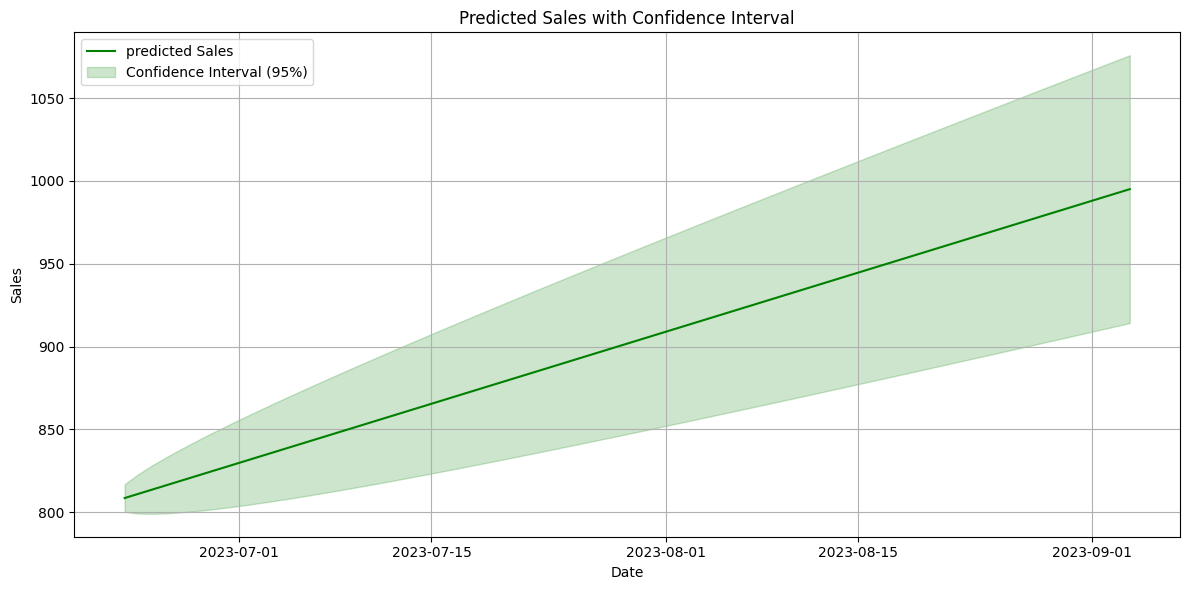

In [33]:
#Coefidence plot
plt.figure(figsize=(12, 6))

#Predicted sales
plt.plot(predicted_sales_df.index, predicted_sales_df['predicted_sales'], label='predicted Sales', color='green')

plt.fill_between(predicted_sales_df.index,
                 predicted_sales_df['lower_ci'],
                 predicted_sales_df['upper_ci'],
                 color='green', alpha=0.2, label='Confidence Interval (95%)')


plt.title('Predicted Sales with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [34]:
#Saving the model
joblib.dump(model_fit, '/workspaces/brayan-tiempo-alternativo/models.pkl')

['/workspaces/brayan-tiempo-alternativo/models.pkl']